In [1]:
!pip install basemap

In [2]:
#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================


def peakiness(waves, **kwargs):  
    
    "finds peakiness of waveforms." 

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \
     
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")
    size=np.shape(waves)[0]
    
    waves1=np.copy(waves)
     
    if waves1.ndim == 1:
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1))
        waves1=waves2

    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky')

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):
        
    from scipy.interpolate import interp1d
        
    time_1hz=SAR_data.variables['time_counter_1Hz'][:]
    time_20hz=SAR_data.variables['time_counter_20Hz'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan) 
        
    if len(out)==len(time_1hz):
            
        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)  

    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    from scipy import asarray as ar,exp
    do_plot='Off'
    
    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])
    
    for i in range(np.shape(RIP)[0]):
    
        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)                          
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])
            
    
    return SSD
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


In [38]:
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree

# dir_path='/content/drive/MyDrive/Research/Data_project/'
dir_path=''
with open(dir_path+'select_files_test.txt') as f:
    selects = [line.rstrip('\n') for line in open(dir_path+'select_files_test.txt')]

with open(dir_path+'matching_SAR_tracks_test.txt') as f:
    matching_SAR_list = [line.rstrip('\n') for line in open(dir_path+'matching_SAR_tracks_test.txt')]
    
j=-1

for file in selects[0:18]:
    startindex=(file.index('S3'))

    j=j+1
#     startindex=(file.index('S3A_OL_1_EFR_'))
#    OLCI_file='/Volumes/cpnet/li1_cpdata/SATS/OPTICAL/OLCI/'+file[startindex:-9]
#    OLCI_file='/Volumes/OLCI/'+file[startindex:-9]
    OLCI_file=dir_path+'OLCI_test/'+file[startindex:-9]  #why is the index -9?
    print('OLCI file', file[startindex:-9])
    tif_file=OLCI_file+'/true_color.tif'    
    
    geo_coords=Dataset(OLCI_file+'/geo_coordinates.nc')
    OLCI_lat=geo_coords['latitude'][:]
    OLCI_lon=geo_coords['longitude'][:]
    OLCI_lon_r=OLCI_lon.ravel()
    OLCI_lat_r=OLCI_lat.ravel()
    
    print('Shape of OLCI lon/lat data:',(OLCI_lon).shape)
    print('Number of OLCI pixels:', len(OLCI_lon_r))
    print('Variable keys for OLCI nc data:')

    # looping over all radaince bands for OLCI_data array    
    OLCI_data=[]
    for Radiance in range(1,22):
        Rstr="%02d" % Radiance
        OLCI_nc=Dataset(OLCI_file+'/Oa'+Rstr+'_radiance.nc')
        print(OLCI_nc.variables.keys())
        OLCI_data.append(np.asarray(OLCI_nc['Oa'+Rstr+'_radiance']))    
              
    #  looping over all radaince bands for OLCI_data array with ravlled elements  
    OLCI_data_r=[]
    for Radiance in range(1,22):
        Rstr="%02d" % Radiance
        OLCI_nc=Dataset(OLCI_file+'/Oa'+Rstr+'_radiance.nc')
        OLCI_data_r.append(np.asarray(OLCI_nc['Oa'+Rstr+'_radiance']).ravel())

    
#     print(OLCI_nc['Oa21_radiance'][:]) 
#     print((OLCI_nc['Oa21_radiance'][:]).shape)  
#     print(np.nanmean(OLCI_nc['Oa21_radiance'][:]))
    print('Number of OLCI radiance bands:', Radiance)
    print('Shape of OLCI data:', np.shape(OLCI_data)) # numpy described 2D arrays (rows, columns) --> (y,x)
    print('Shape of one radiance band of OLCI data:',np.shape(OLCI_data[0]))
    print('Length of a column (number of rows) --> y --> along SAR track direction:',len(OLCI_data[0]))
    print('Length of a row (number of columns) --> x --> across SAR track direction:', len(OLCI_data[0][0])) 
    print('Radiance band 1 OLCI data:')
    print(OLCI_data[0])
#     print(OLCI_data[0][0])
    print('')
    print('Shape of ravelled OLCI data:', np.shape(OLCI_data_r))
    print('Shape of one radiance band of ravelled OLCI data:',np.shape(OLCI_data_r[0]))
    print('Radiance band 1 ravelled OLCI data:')
    print(OLCI_data_r[0])



OLCI file S3B_OL_1_EFR____20190318T022942_20190318T023224_20200112T025628_0162_023_146_1620_MR1_R_NT_002.SEN3
Shape of OLCI lon/lat data: (3688, 4865)
Number of OLCI pixels: 17942120
Variable keys for OLCI nc data:
dict_keys(['Oa01_radiance'])
dict_keys(['Oa02_radiance'])
dict_keys(['Oa03_radiance'])
dict_keys(['Oa04_radiance'])
dict_keys(['Oa05_radiance'])
dict_keys(['Oa06_radiance'])
dict_keys(['Oa07_radiance'])
dict_keys(['Oa08_radiance'])
dict_keys(['Oa09_radiance'])
dict_keys(['Oa10_radiance'])
dict_keys(['Oa11_radiance'])
dict_keys(['Oa12_radiance'])
dict_keys(['Oa13_radiance'])
dict_keys(['Oa14_radiance'])
dict_keys(['Oa15_radiance'])
dict_keys(['Oa16_radiance'])
dict_keys(['Oa17_radiance'])
dict_keys(['Oa18_radiance'])
dict_keys(['Oa19_radiance'])
dict_keys(['Oa20_radiance'])
dict_keys(['Oa21_radiance'])
Number of OLCI radiance bands: 21
Shape of OLCI data: (21, 3688, 4865)
Shape of one radiance band of OLCI data: (3688, 4865)
Length of a column (number of rows) --> y --> along

In [39]:
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree
import netCDF4

# dir_path='/Users/dorsa/Downloads/ProcessIRL_S3_SAR_over_OLCI/'
dir_path='/Users/weibinchen/Desktop/UCL/Research_Intern/AI_radar_research/Weibin_Data_project/'

with open(dir_path+'select_files_test.txt') as f:
    selects = [line.rstrip('\n') for line in open(dir_path+'select_files_test.txt')]
 
with open(dir_path+'matching_SAR_tracks_test.txt') as f:
    matching_SAR_list = [line.rstrip('\n') for line in open(dir_path+'matching_SAR_tracks_test.txt')]

j=-1

CNN_training={}

# nested 
# https://stackoverflow.com/questions/10756427/loop-through-all-nested-dictionary-values
# dic = {}
# dic["key1"] = {}
# dic["key1"]["key1.1"] = "value1"
# selects=glob.glob('/Volumes/cpnet/li1_cpdata/SATS/OPTICAL/OLCI/selects/*.png')

OLCI_file_list_orig=[]
OLCI_file_list=[]
for OLCI_file_orig in selects[0:18]:
    OLCI_file_list_orig.append(OLCI_file_orig)
    startindex=(OLCI_file_orig.index('S3')) # start of the filenmaes in selects list indexed as 1  
    OLCI_file_list.append(OLCI_file_orig[startindex:-9]) # [startindex:-9] takes the .lres.png off the end of the filenames  
   
SAR_file_list=[]
SL_flagfile_list=[]
for OLCI_file in OLCI_file_list: 
    CNN_training[OLCI_file]={} 
       
    j=j+1
#    startindex=(file.index('S3A_OL_1_EFR_'))
#    OLCI_file='/Volumes/cpnet/li1_cpdata/SATS/OPTICAL/OLCI/'+file[startindex:-9]
#    OLCI_file='/Volumes/OLCI/'+file[startindex:-9]
    OLCI_file_p=dir_path+'OLCI_test/'+OLCI_file  # pathhway to OLCI_file
    print('OLCI file is:', selects[j])
    tif_file=OLCI_file_p+'/true_color.tif'
    # Load in instrument data 
    instrument_data = netCDF4.Dataset(OLCI_file_p+'/instrument_data.nc')
    solar_flux = instrument_data.variables['solar_flux'][:]
    solar_flux_Band_Oa01 = solar_flux[0] # Band 1 has index 0 ect. 
    detector_index = instrument_data.variables['detector_index'][:]

# Load in tie geometries
    tie_geometries = netCDF4.Dataset(OLCI_file_p+'/tie_geometries.nc')
    SZA = tie_geometries.variables['SZA'][:]
    
    geo_coords=Dataset(OLCI_file_p+'/geo_coordinates.nc')
    OLCI_lat=geo_coords['latitude'][:]
    OLCI_lon=geo_coords['longitude'][:]
    OLCI_lon_r=OLCI_lon.ravel()
    OLCI_lat_r=OLCI_lat.ravel()
 
    # loop over radiance bands for OLCI_data array:        
    OLCI_data=[]
    for Radiance in range(1,22):
        Rstr="%02d" % Radiance
        OLCI_nc=Dataset(OLCI_file_p+'/Oa'+Rstr+'_radiance.nc')
        width = instrument_data.dimensions['columns'].size
        height = instrument_data.dimensions['rows'].size
        TOA_BRF = np.zeros((height, width), dtype='float32')
        angle=np.zeros((TOA_BRF.shape[0],TOA_BRF.shape[1]))
        for x in range(TOA_BRF.shape[1]):
          angle[:,x]=SZA[:,int(x/64)]

        width = instrument_data.dimensions['columns'].size
        height = instrument_data.dimensions['rows'].size
        TOA_BRF = np.zeros((height, width), dtype=float)
        TOA_BRF=np.pi*np.asarray(OLCI_nc['Oa'+Rstr+'_radiance'])/solar_flux_Band_Oa01[detector_index]/np.cos(np.radians(angle))
        
        OLCI_data.append(TOA_BRF)

    # loop over radiance bands for ravelled OLCI_data array:    
    OLCI_data_r=[]
    for Radiance in range(1,22):
        Rstr="%02d" % Radiance
        OLCI_nc=Dataset(OLCI_file_p+'/Oa'+Rstr+'_radiance.nc')
        OLCI_data_r.append(np.asarray(OLCI_nc['Oa'+Rstr+'_radiance']).ravel())
        CNN_training[OLCI_file]['Oa'+Rstr+'_radiance']=np.asarray(OLCI_nc['Oa'+Rstr+'_radiance'])
    
    CNN_training[OLCI_file]['OLCI_data']=OLCI_data
    CNN_training[OLCI_file]['OLCI_data_r']=OLCI_data_r
    
    print(np.shape(OLCI_data))
    print(np.shape(OLCI_data_r))
       
    # need to find corresponsing SAR file (timecodes are different):
    SAR_file=matching_SAR_list[j]
    SAR_file_list.append(SAR_file)
    print('Overlapping SAR file is:',SAR_file)
    SAR_data=Dataset(dir_path+'GPOD_PROCESSED_test/201803/'+SAR_file)
#    SAR_data=Dataset('/Volumes/cpdata/SATS/RA/S3A/L1B/GPOD_PROCESSED/201803/'+SAR_file)
#    SAR_data=Dataset(dir_path+'/Volumes/GPOD_PROCESSED/201803/'+SAR_file)

    SAR_lat, SAR_lon, waves, sig_0, RIP= unpack_gpod('latitude_20Hz'), unpack_gpod('longitude_20Hz'), unpack_gpod('SAR_Echo_Data'), unpack_gpod('Sigma0_20Hz'), unpack_gpod('Substack_RIP_Data')
    SAR_index=np.arange(np.size(SAR_lat))
    
# still need to do this?  
#     find=np.where(SAR_lat >= -180)
#     SAR_lat=SAR_lat[find]
#     SAR_lon=SAR_lon[find]
#     SAR_index=SAR_index[find]
#     waves=waves[find]
#     sig_0=sig_0[find]
#     RIP=RIP[find]
 
    PP=peakiness(waves)
    SSD=calculate_SSD(RIP)
    
    CNN_training[OLCI_file]["waves"]=waves
    CNN_training[OLCI_file]["sig_0"]=sig_0
    CNN_training[OLCI_file]["RIP"]=RIP
    CNN_training[OLCI_file]["PP"]=PP
    CNN_training[OLCI_file]["SSD"]=SSD
    CNN_training[OLCI_file]["SAR_index"]=SAR_index
    
    SL_flagfile_p=(dir_path+'GPOD_PROCESSED_test/201803/lead_floe_flags/'+SAR_file[0:-7]+'_00_lead.nc')
#     SL_flagfile_p=('/Volumes/GPOD_PROCESSED/201803/lead_floe_flags/'+SAR_file[0:-7]+'_00_lead.nc')
    SL_flagfile=SAR_file[0:-7]+'_00_lead.nc'
    flag_data=Dataset(SL_flagfile_p)
    flag=flag_data['lead_abun_1'][:]
    SL_flagfile_list.append(SL_flagfile)
#     flag_index= np.arange(np.size(flag))   
#     flag=flag[find]

    CNN_training[OLCI_file]["flag_data"]=flag_data
    CNN_training[OLCI_file]["flag"]=flag
#     CNN_training[OLCI_file]["flag_index"]=flag_index

    # convert lons to 360 degree format
    SAR_lon[SAR_lon<0]=360+SAR_lon[SAR_lon<0]
    OLCI_lon[OLCI_lon<0]=360+OLCI_lon[OLCI_lon<0]
    OLCI_lon_r[OLCI_lon_r<0]=360+OLCI_lon_r[OLCI_lon_r<0]
    
    # find centre of OLCI image
    central_lat=np.min(OLCI_lat_r)+0.5*(np.max(OLCI_lat_r)-np.min(OLCI_lat_r))
    central_lon=np.min(OLCI_lon_r)+0.5*(np.max(OLCI_lon_r)-np.min(OLCI_lon_r))
    print('OLCI central lat:', central_lat)
    print('OLCI central lon:', central_lon)
   
    # do Lambert Azimuthal Equal Area Projection (on a equal-area projection, the area is preserved but the shape is not)
    w=1200000
    m = Basemap(resolution='l',projection='laea',ellps='WGS84', lat_ts=0,  lat_0= central_lat, lon_0=central_lon, width=w,height=w)
    SAR_x,SAR_y=m(SAR_lon,SAR_lat)    
    OLCI_x,OLCI_y=m(OLCI_lon,OLCI_lat)
    OLCI_x_r,OLCI_y_r=m(OLCI_lon_r,OLCI_lat_r)

    spec = np.where(PP > 18.0)  # Same as CryoSat-2 
    spec = np.asarray(spec)
    spec = spec.flatten()

    diff = np.where(PP < 9.0)  # Same as CryoSat-2 
    diff = np.asarray(diff)
    diff = diff.flatten()

    spec_SL = np.where(flag==1)[0] # from Sanggyun lead (SL) detection algorithm
    spec_SL = np.asarray(spec_SL)
    spec_SL = spec_SL.flatten()

    diff_SL = np.where(flag==0)[0]
    diff_SL = np.asarray(diff_SL)
    diff_SL = diff_SL.flatten()
    
    
    CNN_training[OLCI_file]["SAR_lon"]=SAR_lon
    CNN_training[OLCI_file]["SAR_lat"]=SAR_lat
    CNN_training[OLCI_file]["SAR_x"]=SAR_x
    CNN_training[OLCI_file]["SAR_y"]=SAR_y
    
    CNN_training[OLCI_file]["OLCI_lon"]=OLCI_lon
    CNN_training[OLCI_file]["OLCI_lat"]=OLCI_lat
    CNN_training[OLCI_file]["OLCI_x"]=OLCI_x
    CNN_training[OLCI_file]["OLCI_y"]=OLCI_y
    CNN_training[OLCI_file]["OLCI_lon_r"]=OLCI_lon_r
    CNN_training[OLCI_file]["OLCI_lat_r"]=OLCI_lat_r
    CNN_training[OLCI_file]["OLCI_x_r"]=OLCI_x_r
    CNN_training[OLCI_file]["OLCI_y_r"]=OLCI_y_r
    
    CNN_training[OLCI_file]["spec"]=spec
    CNN_training[OLCI_file]["diff"]=diff
    CNN_training[OLCI_file]["spec_SL"]=spec_SL
    CNN_training[OLCI_file]["diff_SL"]=diff_SL
    
    
    # do a KDtree to find all OLCI points within a 4km diameter (2km radius) of each SAR footprint.
    points=(OLCI_x_r,OLCI_y_r)
    points=np.transpose(points)
    point_tree = spatial.cKDTree(points)

    nearby_x=[]
    nearby_y=[]
    nearby_z=[]
    match_indices_list=[]
    distances=[]

    for i in range(np.size(SAR_x)): 
        SAR_array=[]
        coordinate=[SAR_x[i],SAR_y[i]]
        
        match_indices=point_tree.query_ball_point(coordinate, 2000) # search radius in metres

        # check distance from each of the OLCI points
        distance_array=[]
        for match_index in match_indices: 
            dist=np.sqrt((OLCI_x_r[match_index]-SAR_x[i])**2+(OLCI_y_r[match_index]-SAR_y[i])**2)
            distance_array.append(dist)
        
        # re-order the nearest OCLI pixels from lowest to highest distance from the SAR point
        paired=tuple(zip(distance_array,match_indices))
        sort_distance=sorted(paired,key=lambda x: x[0]) # key tells function how to sort it (x[0] is distance element)--> lambda functions are basically anonymous functions- iterate over the list
        match_indices_o=[x[1] for x in sort_distance] # distance ordered match indices list
        
        # create an array of distances
        distance_array_2=[]
        for match_index_o in match_indices_o: 
            dist_2=np.sqrt((OLCI_x_r[match_index_o]-SAR_x[i])**2+(OLCI_y_r[match_index_o]-SAR_y[i])**2)
            distance_array_2.append(dist_2)
        distances.append(distance_array_2)
        
        # everything in terms of distance ordered indices (match_indices_o)
        match_indices_list.append(match_indices_o)
        nearby_x.append(OLCI_x_r[match_indices_o])   
        nearby_y.append(OLCI_y_r[match_indices_o])
        
        for Radiance in range(1,22):
            indices_array=[]
            for match_index_o in match_indices_o:
                indices_array.append(OLCI_data_r[Radiance-1][match_index_o])
            SAR_array.append(indices_array)
        nearby_z.append(SAR_array)        

    CNN_training[OLCI_file]["match_indices_list"]=match_indices_list        
    CNN_training[OLCI_file]["nearby_x"]=nearby_x        
    CNN_training[OLCI_file]["nearby_y"]=nearby_y        
    CNN_training[OLCI_file]["nearby_z"]=nearby_z
    CNN_training[OLCI_file]["distances"]=distances  



OLCI file is: S3B_OL_1_EFR____20190318T022942_20190318T023224_20200112T025628_0162_023_146_1620_MR1_R_NT_002.SEN3.lres.png
(21, 3688, 4865)
(21, 17942120)
Overlapping SAR file is: RES_S3B_SR_1_SRA_A__20190318T022739_20190318T031809_20190412T212332_3029_023_146_GPOD_SAR_O_NT_003.nc
Running peakiness function...


/var/folders/vj/y1xmlvz14mx3w9q4j79d5ll80000gn/T/ipykernel_80365/769722203.py:41: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])
/var/folders/vj/y1xmlvz14mx3w9q4j79d5ll80000gn/T/ipykernel_80365/769722203.py:31: RuntimeWarning: All-NaN slice encountered
  maximum=np.nanmax(waves)


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of ca

/var/folders/vj/y1xmlvz14mx3w9q4j79d5ll80000gn/T/ipykernel_80365/769722203.py:129: RuntimeWarning: divide by zero encountered in true_divide
  return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
/var/folders/vj/y1xmlvz14mx3w9q4j79d5ll80000gn/T/ipykernel_80365/769722203.py:129: RuntimeWarning: invalid value encountered in true_divide
  return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
/Users/weibinchen/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/vj/y1xmlvz14mx3w9q4j79d5ll80000gn/T/ipykernel_80365/769722203.py:142: RuntimeWarning: invalid value encountered in double_scalars
  SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
/var/folders/vj/y1xmlvz14mx3w9q4j79d5ll80000gn/T/ipykernel_80365/769722203.py:146: RuntimeWarning: invalid value encountered in double_scalars
  mean_est = sum(x * y) / sum(y)


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of ca

/var/folders/vj/y1xmlvz14mx3w9q4j79d5ll80000gn/T/ipykernel_80365/932211644.py:136: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  flag=flag_data['lead_abun_1'][:]
/var/folders/vj/y1xmlvz14mx3w9q4j79d5ll80000gn/T/ipykernel_80365/932211644.py:136: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  flag=flag_data['lead_abun_1'][:]


OLCI central lat: 76.08012049999999
OLCI central lon: 139.888491


In [5]:
print(np.asarray(OLCI_data))

[[[1034.60621241 1034.60621241 1034.60621241 ...  571.22463293
    571.22463293  567.96722494]
  [1034.31331113 1034.31331113 1034.31331113 ...  571.13317658
    571.13317658  567.87679934]
  [1034.02057709 1034.02057709 1034.02057709 ...  571.04175038
    571.04175038  567.78640339]
  ...
  [ 486.99387318  486.99387318  486.99387318 ...  349.24686295
    349.24686295  348.02180369]
  [ 486.93301415  486.93301415  486.93301415 ...  349.21484794
    349.21484794  347.99001843]
  [ 486.87217097  486.87217097  486.87217097 ...  349.18285379
    349.18285379  347.9582395 ]]

 [[1034.60621241 1034.60621241 1034.60621241 ...  571.22463293
    571.22463293  567.96722494]
  [1034.31331113 1034.31331113 1034.31331113 ...  571.13317658
    571.13317658  567.87679934]
  [1034.02057709 1034.02057709 1034.02057709 ...  571.04175038
    571.04175038  567.78640339]
  ...
  [ 486.99387318  486.99387318  486.99387318 ...  349.24686295
    349.24686295  348.02180369]
  [ 486.93301415  486.93301415  486.

In [7]:
# understanding ravel 
for OLCI_file in OLCI_file_list: 
    if OLCI_file==OLCI_file_list[0]: # change this to look at other images/tracks  
        OLCI_x=CNN_training[OLCI_file]['OLCI_x']
        OLCI_x_r=CNN_training[OLCI_file]['OLCI_x_r']
        print(OLCI_x[0,1])
        print(OLCI_x_r[1])
        # shows it ravels the data row by row 

206940.96082346904
206940.96082346904


In [8]:
# converting OLCI pixel into image array format
index0=[] # in flight direction (y values indexed) -
index1=[] # accross flight direction (x values indexed) 
k=0
for OLCI_file in OLCI_file_list:
    index0_1=[]
    index1_1=[]
    k=k+1
    for i in range((CNN_training[OLCI_file]['OLCI_x']).shape[0]):     # no.rows (y)
        for j in range((CNN_training[OLCI_file]['OLCI_x']).shape[1]): # no.columns (x)
            index0_1.append(i)  # gives y values for each point in row (will be the same for one row)
            index1_1.append(j)  # gives x values for for each point in row  
    index0.append(index0_1)
    index1.append(index1_1)
   

    print('Number of OLCI pixels for image',k)
    print(np.shape(index0_1))
#     print(np.shape(index1_each))

    # try it for a few OLCI pixels 
#     print((index0_1[4795637],index1_1[4795637]))
#     print((index0_1[2066377],index1_1[2066377]))
#     print((index0_1[387954],index1_1[387954]))

Number of OLCI pixels for image 1
(17942120,)
Number of OLCI pixels for image 2
(18545380,)
Number of OLCI pixels for image 3
(18701060,)
Number of OLCI pixels for image 4
(19902715,)
Number of OLCI pixels for image 5
(19897850,)
Number of OLCI pixels for image 6
(19902715,)


In [9]:
# which SAR points lie on image --> some that are just off the edge of image are counted as well  
SAR_on_OLCI=[]
j=-1
for OLCI_file in OLCI_file_list:
    j=j+1
    SAR_on_OLCI_each=[]
    for i in range(np.size(CNN_training[OLCI_file]["SAR_lon"])):       
            if len(CNN_training[OLCI_file]['match_indices_list'][i])>0:
                SAR_on_OLCI_each.append(i)
    SAR_on_OLCI.append(SAR_on_OLCI_each)            

    min_value=min(SAR_on_OLCI_each)
    max_value=max(SAR_on_OLCI_each)
    print('The SAR points that lie over the OLCI image for', j+1, 'are approximately between:', min_value, 'to', max_value, '(approx', np.shape(SAR_on_OLCI_each), 'points)')
       

The SAR points that lie over the OLCI image for 1 are approximately between: 2456 to 5727 (approx (3272,) points)
The SAR points that lie over the OLCI image for 2 are approximately between: 2345 to 5726 (approx (3382,) points)
The SAR points that lie over the OLCI image for 3 are approximately between: 2251 to 5661 (approx (3411,) points)
The SAR points that lie over the OLCI image for 4 are approximately between: 1993 to 5621 (approx (3629,) points)
The SAR points that lie over the OLCI image for 5 are approximately between: 2100 to 5727 (approx (3628,) points)
The SAR points that lie over the OLCI image for 6 are approximately between: 1977 to 5605 (approx (3629,) points)


In [10]:
k=-1
for OLCI_file in OLCI_file_list: 
    k=k+1
    match_indices_list=CNN_training[OLCI_file]['match_indices_list']
    SAR_on_OLCI_n=SAR_on_OLCI[k]   
    min_value_n=(min(SAR_on_OLCI_n)+50)
    max_value_n=(max(SAR_on_OLCI_n)-50)
        
    close_OLCI_1=match_indices_list[min_value_n][0]
    close_OLCI_2=match_indices_list[max_value_n][0]
        
    # using the OLCI points closest to SAR points at edges of images 
    print('Two OLCI pixel points in array format where SAR overlaps for',k+1)
    print((index0[k][close_OLCI_1]),(index1[k][close_OLCI_1])) 
    print((index0[k][close_OLCI_2]),(index1[k][close_OLCI_2])) 
    print('')

Two OLCI pixel points in array format where SAR overlaps for 1
51 3612
3637 3612

Two OLCI pixel points in array format where SAR overlaps for 2
50 3612
3760 3612

Two OLCI pixel points in array format where SAR overlaps for 3
50 3612
3793 3611

Two OLCI pixel points in array format where SAR overlaps for 4
50 3612
4040 3612

Two OLCI pixel points in array format where SAR overlaps for 5
50 3612
4038 3611

Two OLCI pixel points in array format where SAR overlaps for 6
50 3612
4040 3612



In [11]:
import geopy.distance

for OLCI_file in OLCI_file_list: 
    if OLCI_file==OLCI_file_list[0]: # change this to look at other images/tracks
        OLCI_lat=CNN_training[OLCI_file]['OLCI_lat']
        OLCI_lon=CNN_training[OLCI_file]['OLCI_lon']

        print('Distance between consecutive OLCI points in flight direction (y direction):')
        coords_1 = (OLCI_lat[100,100], OLCI_lon[100,100])
        coords_2 = (OLCI_lat[99,100], OLCI_lon[99,100])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1000,1000], OLCI_lon[1000,1000])
        coords_2 = (OLCI_lat[999,1000], OLCI_lon[999,1000])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1000,2000], OLCI_lon[1000,2000])
        coords_2 = (OLCI_lat[999,2000], OLCI_lon[999,2000])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1100,4000], OLCI_lon[1100,4000])
        coords_2 = (OLCI_lat[1099,4000], OLCI_lon[1099,4000])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)
        print('')

        print('Distance between consecutive OLCI points across flight direction (x direction):')
        coords_1 = (OLCI_lat[100,100], OLCI_lon[100,100])
        coords_2 = (OLCI_lat[100,99], OLCI_lon[100,99])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1000,1000], OLCI_lon[1000,1000])
        coords_2 = (OLCI_lat[1000,999], OLCI_lon[1000,999])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1000,2000], OLCI_lon[1000,2000])
        coords_2 = (OLCI_lat[1000,1999], OLCI_lon[1000,1999])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1100,4000], OLCI_lon[1100,4000])
        coords_2 = (OLCI_lat[1100,3999], OLCI_lon[1100,3999])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1100,1100], OLCI_lon[1100,1100])
        coords_2 = (OLCI_lat[1100,1099], OLCI_lon[1100,1099])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1100,1100], OLCI_lon[1100,1100])
        coords_2 = (OLCI_lat[1100,1101], OLCI_lon[1100,1101])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

Distance between consecutive OLCI points in flight direction (y direction):
284.6842789312862
287.82369385949977
290.5687967913469
294.6476717963507

Distance between consecutive OLCI points across flight direction (x direction):
270.0159016888073
0.0
368.6036832869988
275.242020056589
512.2487200484003
0.0


In [11]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [12]:
for OLCI_file in OLCI_file_list: 
    if OLCI_file==OLCI_file_list[0]: # change this to look at other images/tracks
        OLCI_y=CNN_training[OLCI_file]['OLCI_y']
        OLCI_x=CNN_training[OLCI_file]['OLCI_x']
           
        print('Distance between consecutive OLCI points in flight direction (y direction):')
        print(np.sqrt((OLCI_x[100,100]-OLCI_x[99,100])**2+((OLCI_y[100,100]-OLCI_y[99,100])**2)))
        print(np.sqrt((OLCI_x[1000,1000]-OLCI_x[999,1000])**2+((OLCI_y[1000,1000]-OLCI_y[999,1000])**2)))
        print(np.sqrt((OLCI_x[1000,2000]-OLCI_x[999,2000])**2+((OLCI_y[1000,2000]-OLCI_y[999,2000])**2)))
        print(np.sqrt((OLCI_x[1100,4000]-OLCI_x[1099,4000])**2+((OLCI_y[1100,4000]-OLCI_y[1099,4000])**2)))
        print('')

        print('Distance between consecutive OLCI points across flight direction (x direction):')
        print(np.sqrt((OLCI_x[100,100]-OLCI_x[100,99])**2+((OLCI_y[100,100]-OLCI_y[100,99])**2)))
        print(np.sqrt((OLCI_x[1000,1000]-OLCI_x[1000,999])**2+((OLCI_y[1000,1000]-OLCI_y[1000,999])**2)))
        print(np.sqrt((OLCI_x[1000,2000]-OLCI_x[1000,1999])**2+((OLCI_y[1000,2000]-OLCI_y[1000,1999])**2)))
        print(np.sqrt((OLCI_x[1100,4000]-OLCI_x[1100,3999])**2+((OLCI_y[1100,4000]-OLCI_y[1100,3999])**2)))

        print(np.sqrt((OLCI_x[1100,1100]-OLCI_x[1100,1099])**2+((OLCI_y[1100,1100]-OLCI_y[1100,1099])**2))) 
        print(np.sqrt((OLCI_x[1100,1100]-OLCI_x[1100,1101])**2+((OLCI_y[1100,1100]-OLCI_y[1100,1101])**2))) 
        

Distance between consecutive OLCI points in flight direction (y direction):
284.89811116542654
287.97040707718685
290.54551657641673
294.68552234498827

Distance between consecutive OLCI points across flight direction (x direction):
269.81745456586225
0.0
368.6329053670681
275.206732744362
512.0034241102004
0.0


In [44]:
from sklearn.model_selection import train_test_split

# As input, a CNN takes tensors of shape (image_height, image_width, color_channels)
# N is the number of training images, Nv is the number of validation images, Nt is the number of test images
# train_images=np.zeros((N,11,11,21)) 
# validation_images=np.zeros((Nv,11,11,20))
# test_images=np.zeros((Nt,11,11,20))
# train_labels=np.zeros((N))
# validation_labels=np.zeros((Nv))
# train_labels=np.zeros((Nt))


# no seperation between files 
images_n=[] # all 11x11 images (not array)
labels_n=[] # labels for 11x11 images (not array)
indices_n=[] # all SAR indices which correspond to 11x11 images 
files_n=[] # file number associated with each element in lists above 

# each element is for one file 
images_k=[]
labels_k=[]
indices_k=[]

n=-1
for OLCI_file in OLCI_file_list:
    n=n+1
    match_indices_list=CNN_training[OLCI_file]['match_indices_list'] 
    flag=CNN_training[OLCI_file]['flag']
    OLCI_data=CNN_training[OLCI_file]['OLCI_data']    
    SAR_lon=CNN_training[OLCI_file]['SAR_lon']
    # for each file 
    images_e=[] 
    labels_e=[]
    indices_e=[]     
    for i in range(np.size(SAR_lon)):
        if len(match_indices_list[i])>0:
            OLCI_closest=match_indices_list[i][0] # index of closest OLCI point to SAR point
            i0=index0[n][OLCI_closest]
            i1=index1[n][OLCI_closest]   
            image_temp=np.zeros((67,67,21))
            if OLCI_data[0][i0-33:i0+34,i1-33:i1+34].shape==(67,67):
                for r in range(1,22):            
                    image_temp[:,:,r-1]=OLCI_data[r-1][i0-33:i0+34,i1-33:i1+34]
                images_n.append(image_temp)   
                labels_n.append(flag[i])
                indices_n.append(i)
                files_n.append(n+1) # file naming starts from 1
                images_e.append(image_temp)   
                labels_e.append(flag[i])
                indices_e.append(i)                
    images_k.append(images_e)   
    labels_k.append(labels_e)
    indices_k.append(indices_e)
    
    
# each element is for one file- can use for checks
labels_k1=[]
images_k1=[]
indices_k1=[]
labels_k0=[]
images_k0=[]
indices_k0=[]   
for i in range(len(indices_k)):    
    labels_k_e=np.asarray(labels_k[i])
    images_k_e=np.asarray(images_k[i])
    indices_k_e=np.asarray(indices_k[i])
    
    labels_k1_e=labels_k_e[labels_k_e==1]
    images_k1_e=images_k_e[labels_k_e==1]
    indices_k1_e=indices_k_e[labels_k_e==1]
    labels_k0_e=labels_k_e[labels_k_e==0]
    images_k0_e=images_k_e[labels_k_e==0]
    indices_k0_e=indices_k_e[labels_k_e==0]
    
    labels_k1.append(labels_k1_e)
    images_k1.append(images_k1_e)
    indices_k1.append(indices_k1_e)
    labels_k0.append(labels_k0_e)
    images_k0.append(images_k0_e)
    indices_k0.append(indices_k0_e)


# turning lists into arrays 
images_n_a=np.asarray(images_n)
indices_n_a=np.asarray(indices_n)
labels_n_a=np.asarray(labels_n)
files_n_a=np.asarray(files_n)    

# using equal number of observations for each class
labels1=labels_n_a[labels_n_a==1.0]
labels0_a=labels_n_a[labels_n_a==0.0]
n=len(labels1)
labels0=labels0_a[:n]

images1=images_n_a[labels_n_a==1.0,:,:,:]
images0_a=images_n_a[labels_n_a==0.0,:,:,:]
images0=images0_a[:n]

indices1=indices_n_a[labels_n_a==1.0]
indices0_a=indices_n_a[labels_n_a==0.0]
indices0=indices0_a[:n]

files1=files_n_a[labels_n_a==1.0]
files0_a=files_n_a[labels_n_a==0.0]
files0=files0_a[:n]

# creating 50/50 lead/sea-ice datasets    
labels_cnn=np.concatenate((labels1,labels0))
files_cnn=np.concatenate((files1,files0))
indices_cnn=np.concatenate((indices1,indices0))
images_cnn=np.concatenate((images1,images0))

print(images_cnn.shape)
    
# ###SPLITTING INTO TRAINING, VALIDATION AND TESTING DATA###
# random_state simply sets a seed to the random generator, so that your train-test splits are always deterministic. If you don't set a seed, it is different each time
train_images,validation_images,train_labels,validation_labels,train_indices,validation_indices,train_files,validation_files= train_test_split(images_cnn,labels_cnn,indices_cnn,files_cnn, test_size=0.5, random_state=42)
validation_images,test_images,validation_labels,test_labels,validation_indices,test_indices,validation_files,test_files= train_test_split(validation_images,validation_labels,validation_indices,validation_files, test_size=0.45, random_state=42)

(172, 67, 67, 21)


In [56]:
#Save the data in the form of numpy arrays
np.save('x_train96', train_images)
np.save('x_test96', test_images)
np.save('y_train96', train_labels)
np.save('y_test96', test_labels)

In [46]:
print(train_images.shape)

(925, 3, 3, 21)


[[[1580.35199139 1580.35199139 1580.35199139 ...  690.9051592
    690.9051592   685.91264313]
  [1579.66729962 1579.66729962 1579.66729962 ...  690.77098445
    690.77098445  685.7804386 ]
  [1578.98288171 1578.98288171 1578.98288171 ...  690.63692334
    690.63692334  685.64828604]
  ...
  [ 616.24660389  616.24660389  616.24660389 ...  406.33729448
    406.33729448  404.59918981]
  [ 616.14720709  616.14720709  616.14720709 ...  406.29307802
    406.29307802  404.55535423]
  [ 616.04784315  616.04784315  616.04784315 ...  406.24889192
    406.24889192  404.51152873]]

 [[1580.35199139 1580.35199139 1580.35199139 ...  690.9051592
    690.9051592   685.91264313]
  [1579.66729962 1579.66729962 1579.66729962 ...  690.77098445
    690.77098445  685.7804386 ]
  [1578.98288171 1578.98288171 1578.98288171 ...  690.63692334
    690.63692334  685.64828604]
  ...
  [ 616.24660389  616.24660389  616.24660389 ...  406.33729448
    406.33729448  404.59918981]
  [ 616.14720709  616.14720709  616.14

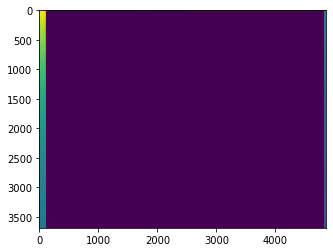

In [40]:
print(np.asarray(OLCI_data))
plt.imshow(np.asarray(OLCI_data)[20,:,:])

[[0.60348432 0.60158195 0.61639352 ... 0.64916805 0.64828087 0.64969219]
 [0.59922089 0.60013732 0.61595216 ... 0.64702425 0.64563771 0.64754823]
 [0.61085984 0.60865649 0.61581294 ... 0.64528102 0.64109783 0.64690364]
 ...
 [0.64618683 0.64024329 0.62903974 ... 0.65367987 0.65457892 0.65606911]
 [0.64266937 0.63613176 0.63376178 ... 0.65452049 0.65325233 0.65424965]
 [0.6405422  0.62924426 0.63540633 ... 0.65299731 0.65025225 0.6505599 ]]


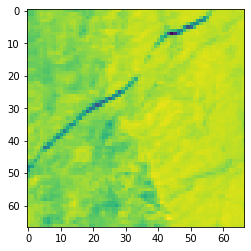

In [51]:
import matplotlib.pyplot as plt
print((images_cnn[100,:,:,10]))
plt.imshow(images_cnn[100,:,:,10])

[[0.84618576 0.84415095 0.83869884]
 [0.84135078 0.82947751 0.82265968]
 [0.81315615 0.78297761 0.82780444]]


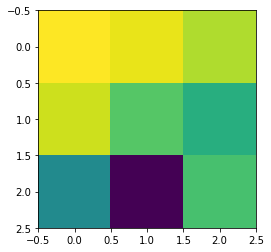

In [35]:
import matplotlib.pyplot as plt
print((images_cnn[0,:,:,1]))
plt.imshow(images_cnn[0,:,:,1])

In [36]:
import numpy as np
#width = instrument_data.dimensions['columns'].size
#height = instrument_data.dimensions['rows'].size

TOA_BRF = np.zeros((3, 3), dtype='float32')
angle=np.zeros((TOA_BRF.shape[0],TOA_BRF.shape[1]))
for x in range(TOA_BRF.shape[1]):
  angle[:,x]=SZA[:,int(x/64)]

TOA_BRF = np.zeros((3, 3), dtype=float)
TOA_BRF=np.pi*images_cnn[0,:,:,1]/solar_flux_Band_Oa01[detector_index]/np.cos(np.radians(angle))

NameError: name 'SZA' is not defined